In [1]:
from glob import glob
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import clr
from matplotlib_venn import venn3

sns.set_context('talk')
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

# Metabolomics correlations
##### 7/18/22
##### Michael Shaffer
##### Merck ESC, Sys bio group

After some success with correlating KOs with continuous titer we decided to use the same approach on the metabolomics data. This data table came from Tom directly.

## Read in data

Read in the excel table from Tom and fill out empty cells with zeros.

In [2]:
metab_data = pd.read_excel('../../data/metabolomics_abunds.xlsx', index_col=0).fillna(0)
metab_data = metab_data.drop('2-Methyl-1-butanol', axis=1) # drop 2-methyl-1-butanol
metab_data.head()

,GCDCA,GDCA,GHDCA or GUDCA,CA,TCDCA,TCA,CDCA,7oxoCA,TUDCA,UDCA or HDCA,...,Uracil,Adenosine,Phenaceturic acid,N-Acetyl D-galactosamine,Pyridoxal hydrochloride,2-Deoxyuridine,Vanillic acid,Thymine,Nicotinic acid,Homocitrate
Compound name,,,,,,,,,,,,,,,,,,,,,
P103_V12_05052020,13165.576990,6486.205847,1037.427698,877.477368,842.441112,428.399288,412.663454,6.309238,26.103778,37.617317,...,571,112,45,90,426,1223,6865,549,217,3044
P106_V9_04022019,5324.081005,615.267690,1431.812977,536.910350,477.807838,761.254736,55.773899,4.142229,91.815489,19.861706,...,400,368,206,217,201,372,53,230,216,109
P107_A1_04152019,11967.195030,3.048386,8876.579286,884.309058,2720.613568,3492.197205,106.185518,7.807234,664.956760,113.460800,...,594,112,8,330,102,9,87,55,177,6952
P108_V9_04022019,117.128627,-0.240781,116.125243,29.790592,6.916959,5.775257,1.574994,0.418815,1.671431,4.996911,...,60,226,11,16,249,104,64,18,24,36
P108_V12_05212020,16651.224940,1707.969274,3575.590198,1277.281488,2356.663104,1109.351448,204.781749,41.696046,216.707453,107.961759,...,375,184,205,141,253,702,298,196,196,3468


In [3]:
len(metab_data.columns)

111

111 total compounds.

In [4]:
(metab_data < 0).sum().sum()

34

There are only 34 negative values in the data set so not much to worry about.

In [5]:
metab_data.unstack()[metab_data.unstack() < 0]

        Compound name    
GDCA    P108_V9_04022019    -0.240781
        P134_V9_12062019    -3.462650
        P136_V9_01092020    -3.398780
        P136_V12_01042021   -0.059861
        P202_V12_02252020   -1.708202
        P212_V5_05232018    -2.539283
        P215_V9_03292019    -4.984036
        P215_V12_03302020   -2.424750
        P217_V5_06122018    -1.613075
        P217_V9_04122019    -0.517431
        P218_V5_06062018    -0.427326
        P220_V5_06132018    -0.218075
        P224_V9_05292019    -0.396865
        P229_V5_07022018    -0.664653
        P235_V5_08152018    -0.203266
        P237_V9_06242019    -0.407863
        P239_V5_08292018    -0.942639
        P246_V10_10032019   -1.541833
        P250_V5_11062018    -1.424605
        P250_V9_09092019    -2.380330
        P252_V9_09102019    -1.033160
        P256_V9_10082018    -0.539685
        P258_V5_01032019    -1.193836
        P260_V9_11072019    -7.410659
        P261_V5_01032019    -2.489533
        P263_V9_11262019

There are negative numbers in the data set. Checked with Tom and he said that these can be treated as zeros. So do that.

In [6]:
# Replace negative numbers with 0 as Tom said in an email
metab_data[metab_data < 0] = 0
(metab_data == 0).sum().sum()

38

Relative abundance normalized version of table is calculated by summing rows and dividing column values by totals. Makes it so that values are percent abundances of sample.

In [7]:
metab_data_rel = metab_data.div(metab_data.sum(axis=1), axis=0)
metab_data_rel.head()

,GCDCA,GDCA,GHDCA or GUDCA,CA,TCDCA,TCA,CDCA,7oxoCA,TUDCA,UDCA or HDCA,...,Uracil,Adenosine,Phenaceturic acid,N-Acetyl D-galactosamine,Pyridoxal hydrochloride,2-Deoxyuridine,Vanillic acid,Thymine,Nicotinic acid,Homocitrate
Compound name,,,,,,,,,,,,,,,,,,,,,
P103_V12_05052020,0.001680,8.275956e-04,0.000132,0.000112,0.000107,0.000055,5.265304e-05,8.050157e-07,3.330664e-06,0.000005,...,0.000073,0.000014,0.000006,0.000011,0.000054,0.000156,0.000876,0.000070,0.000028,0.000388
P106_V9_04022019,0.000847,9.783810e-05,0.000228,0.000085,0.000076,0.000121,8.869005e-06,6.586853e-07,1.460024e-05,0.000003,...,0.000064,0.000059,0.000033,0.000035,0.000032,0.000059,0.000008,0.000037,0.000034,0.000017
P107_A1_04152019,0.002120,5.401497e-07,0.001573,0.000157,0.000482,0.000619,1.881523e-05,1.383380e-06,1.178250e-04,0.000020,...,0.000105,0.000020,0.000001,0.000058,0.000018,0.000002,0.000015,0.000010,0.000031,0.001232
P108_V9_04022019,0.000065,0.000000e+00,0.000065,0.000017,0.000004,0.000003,8.751132e-07,2.327061e-07,9.286966e-07,0.000003,...,0.000033,0.000126,0.000006,0.000009,0.000138,0.000058,0.000036,0.000010,0.000013,0.000020
P108_V12_05212020,0.002614,2.681638e-04,0.000561,0.000201,0.000370,0.000174,3.215225e-05,6.546587e-06,3.402467e-05,0.000017,...,0.000059,0.000029,0.000032,0.000022,0.000040,0.000110,0.000047,0.000031,0.000031,0.000545


CLR normalized version of table is calculated using CLR (centered log ratio transformation) which controls for compositionality. This is done using the scikit-bio package.

In [8]:
metab_data_clr = pd.DataFrame(clr(metab_data + .001), index=metab_data.index, columns=metab_data.columns)

Build simple metadata table based on the sample names from the metabolomics table.

In [9]:
meta_rows = [[i, int(i.split('_')[0].strip('P')), i.split('_')[1], i.split('_')[-1]] for i in metab_data.index]
meta_base = pd.DataFrame(meta_rows, columns=['SampleID', 'BabyN', 'VisitCode', 'VisitDate']).set_index('SampleID')
meta_base.head()

,BabyN,VisitCode,VisitDate
SampleID,,,
P103_V12_05052020,103,V12,05052020
P106_V9_04022019,106,V9,04022019
P107_A1_04152019,107,A1,04152019
P108_V9_04022019,108,V9,04022019
P108_V12_05212020,108,V12,05212020


Connect sample data to 1 yr titer data via the baby numbers.

In [10]:
titer_data = pd.read_csv('../../data/vaccine_response/vaccine_response_y2.tsv', sep='\t', index_col=0)
titer_data.index = [int(i.split('Baby')[-1]) for i in titer_data.index]
titer_data.head()

,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,PCV ST5,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
103,47.0,1.54,186.0,326.0,3.60,6.18,111.189953,46.960230,79.307349,82.640316,...,0.190854,0.326317,0.146465,True,True,True,True,True,True,NVR
108,31.0,1.21,34.0,43.0,2.12,4.15,36.929565,31.828768,82.189284,108.892504,...,0.168430,0.172291,0.164958,True,True,True,True,True,True,NVR
110,37.0,0.62,15.0,85.0,3.45,13.16,85.710344,58.493770,135.699571,416.070794,...,0.298568,0.237230,0.358166,True,True,True,True,True,True,NVR
112,11.0,0.23,22.0,68.0,0.79,14.69,118.861585,48.999537,92.404780,179.132640,...,0.358315,0.085661,0.468588,True,True,True,True,True,True,NVR
113,146.0,0.38,37.0,137.0,2.70,18.61,56.092263,17.140494,82.645151,196.584328,...,0.221124,0.298591,0.221124,True,True,True,True,True,True,NVR


Use BabyN to connect compound abundance to titer values since there is only one 2 month sample and one set of 1 year titer values per baby.

In [11]:
per_sample_titer_data = pd.DataFrame({sample: titer_data.loc[i] for sample, i in meta_base['BabyN'].iteritems() if i in titer_data.index}).transpose()
per_sample_titer_data.head()

,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,PCV ST3,PCV ST4,PCV ST5,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
P103_V12_05052020,47.0,1.54,186.0,326.0,3.6,6.18,111.189953,46.96023,79.307349,82.640316,...,0.190854,0.326317,0.146465,True,True,True,True,True,True,NVR
P108_V9_04022019,31.0,1.21,34.0,43.0,2.12,4.15,36.929565,31.828768,82.189284,108.892504,...,0.16843,0.172291,0.164958,True,True,True,True,True,True,NVR
P108_V12_05212020,31.0,1.21,34.0,43.0,2.12,4.15,36.929565,31.828768,82.189284,108.892504,...,0.16843,0.172291,0.164958,True,True,True,True,True,True,NVR
P110_V9_05172019,37.0,0.62,15.0,85.0,3.45,13.16,85.710344,58.49377,135.699571,416.070794,...,0.298568,0.23723,0.358166,True,True,True,True,True,True,NVR
P110_V12_05132020,37.0,0.62,15.0,85.0,3.45,13.16,85.710344,58.49377,135.699571,416.070794,...,0.298568,0.23723,0.358166,True,True,True,True,True,True,NVR


Merge sample metadata and titer data, filter out samples without one year titers.

In [12]:
meta = pd.concat([meta_base, per_sample_titer_data], axis=1)
meta = meta.loc[~pd.isna(meta['VR_group'])]
meta.head()

,BabyN,VisitCode,VisitDate,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
P103_V12_05052020,103,V12,05052020,47.0,1.54,186.0,326.0,3.6,6.18,111.189953,...,0.190854,0.326317,0.146465,True,True,True,True,True,True,NVR
P108_V9_04022019,108,V9,04022019,31.0,1.21,34.0,43.0,2.12,4.15,36.929565,...,0.16843,0.172291,0.164958,True,True,True,True,True,True,NVR
P108_V12_05212020,108,V12,05212020,31.0,1.21,34.0,43.0,2.12,4.15,36.929565,...,0.16843,0.172291,0.164958,True,True,True,True,True,True,NVR
P110_V9_05172019,110,V9,05172019,37.0,0.62,15.0,85.0,3.45,13.16,85.710344,...,0.298568,0.23723,0.358166,True,True,True,True,True,True,NVR
P110_V12_05132020,110,V12,05132020,37.0,0.62,15.0,85.0,3.45,13.16,85.710344,...,0.298568,0.23723,0.358166,True,True,True,True,True,True,NVR


Find shared samples between the metadata and metabolomics data. Filter metadata to match the metabolomics.

In [13]:
in_both = list(set(meta.index) & set(metab_data.index))
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(120, 51)


In [14]:
meta_matched['VisitCode'].value_counts()

V12    49
V9     37
V5     28
V10     3
A1      1
V6      1
A3      1
Name: VisitCode, dtype: int64

Plurality of samples from 1 year. Many from 2 months and 2 years as well. We will focus on two months (V5) and 1 year (V9).

## Do correlation with un-normalized data

First take the "raw" data (not further normalized from what Tom gave me) and correlate each feature with the mei.

### 2 months (V5) correlations

First focus on the 2 month time points.

We are using spearman for all of these correlations and multiple testing correction with Benjamini-Hochberg.

In [15]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")
metab_data_v5 = metab_data.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations = metab_data_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
print(len(v5_correlations), len(v5_correlations.query('p_value < .05')), len(v5_correlations.query('p_adj < .05')))
v5_correlations.head(14)

111 4 0


,rho,p_value,p_adj
5-HIAA,0.448276,0.016738,0.914287
Guanosine,0.430820,0.022096,0.914287
Uridine,-0.391352,0.039457,0.914287
hydroxyphenyllactate,-0.389710,0.040366,0.914287
p-cresol sulfate,0.367269,0.054530,0.914287
Nicotinic acid,-0.357417,0.061865,0.914287
N-Carbamoyl-DL-aspartic acid,-0.343186,0.073789,0.914287
Thymine,-0.334793,0.081605,0.914287
Melibiose,0.327905,0.088481,0.914287
serotonin,0.319650,0.097289,0.914287


13 compounds with raw p-values less than .05 and 1 compound with adjusted p-value less than .05.

Now save correlations to file.

#### Plot phenylpyruvic acid result

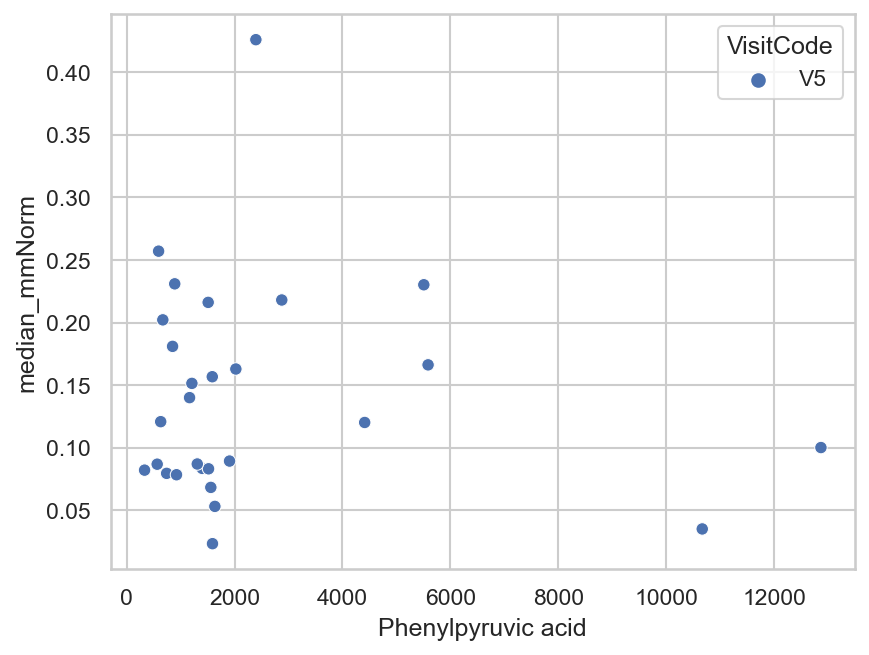

In [16]:
_ = sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm', hue='VisitCode',
                   data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V5'"))

Plot log phenylpyruvic acid abundance vs median normalized titer.

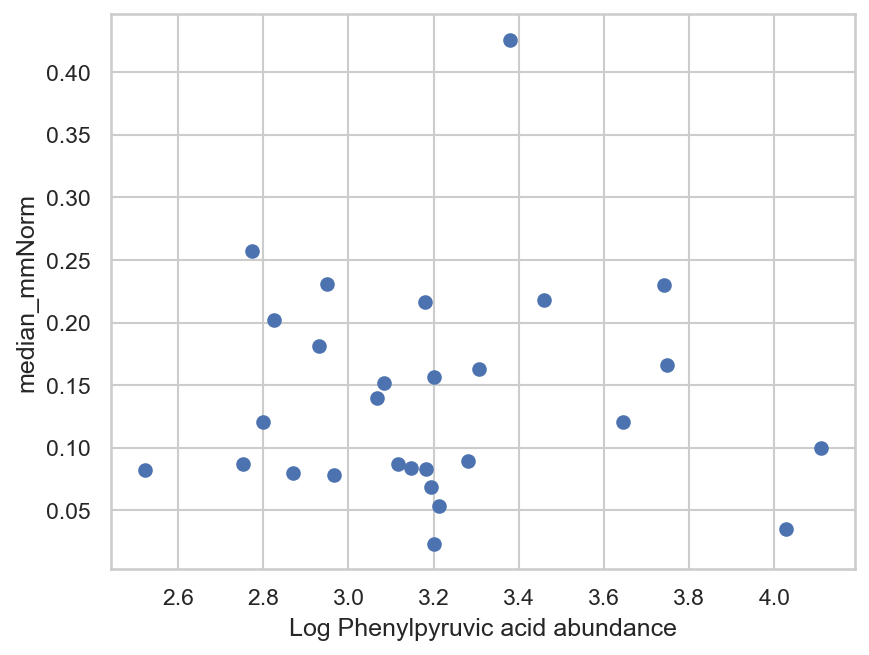

In [17]:
_ = plt.scatter(np.log10(metab_data.loc[meta_matched.query("VisitCode == 'V5'").index, 'Phenylpyruvic acid']), meta_matched.query("VisitCode == 'V5'")['median_mmNorm'])
_ = plt.xlabel('Log Phenylpyruvic acid abundance')
_ = plt.ylabel('median_mmNorm')

Plot ranks against each other since this is what spearman is actually using.

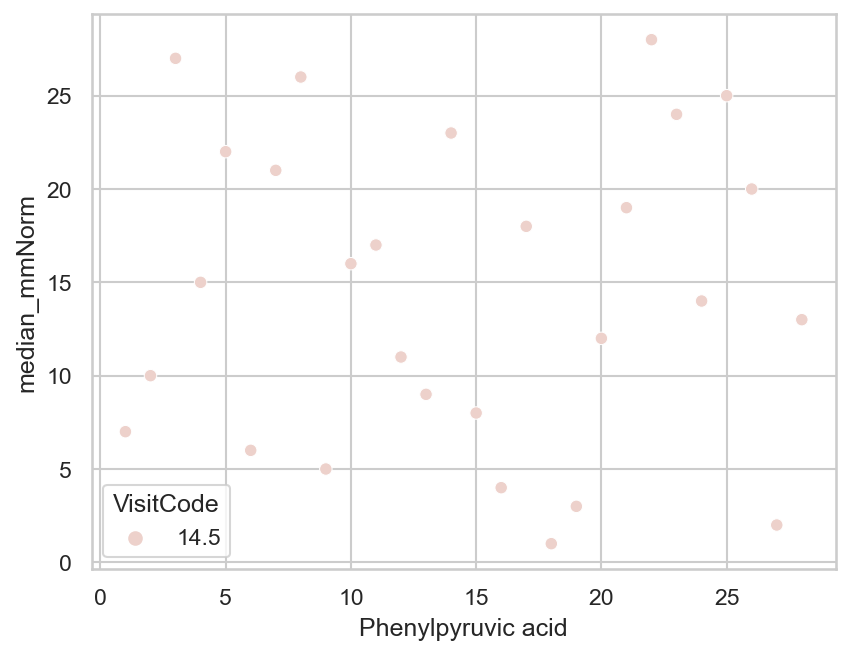

In [18]:
_ =sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm', hue='VisitCode',
                   data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V5'").rank())

### 1 year (V9) correlations

Same correlations but with year 1 un-normalized data.

In [19]:
meta_v9 = meta_matched.query("VisitCode == 'V9'")
metab_data_v9 = metab_data.loc[meta_v9.index]
# metab_data_v9 = metab_data_v9[(metab_data_v9 > 0).sum(axis=0) > metab_data_v9.shape[0]*.2]
v9_correlations = metab_data_v9.apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations = v9_correlations.loc[~pd.isna(v9_correlations['p_value'])]
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
print(len(v9_correlations), len(v9_correlations.query('p_value < .05')), len(v9_correlations.query('p_adj < .05')))
v9_correlations.head(46)

111 3 0


,rho,p_value,p_adj
trans-4-Hydroxy-L-proline,-0.431247,0.007703,0.854997
L-Serine,-0.338312,0.040553,0.970479
L-Threonine,-0.336890,0.041458,0.970479
Succinic acid,-0.292319,0.079148,0.970479
Nicotinic acid,-0.291304,0.080243,0.970479
L-Aspartic Acid,-0.283547,0.089008,0.970479
N-Acetyl D-galactosamine,-0.269710,0.106452,0.970479
L-Glutamine,-0.263395,0.115225,0.970479
2-Deoxyuridine,0.261514,0.117940,0.970479
N-Acetylneuraminic acid,-0.255571,0.126835,0.970479


45 compounds have significant adjusted p-values. 62 significant raw p-values. So about half of things are significant. Is this an artifact or does it mean that base metabolism is associated with titer response?

Tryptophan D5 is in this list. It is a control compound so we probably shouldn't trust this.

In [20]:
v9_correlations.loc[[i for i in v9_correlations.index if 'D5' in i]]

,rho,p_value,p_adj
L-tryptophan-D5,0.116406,0.492647,0.970479


#### 5-HIAA

At 1 year correlation between 5-HIAA and median titer.

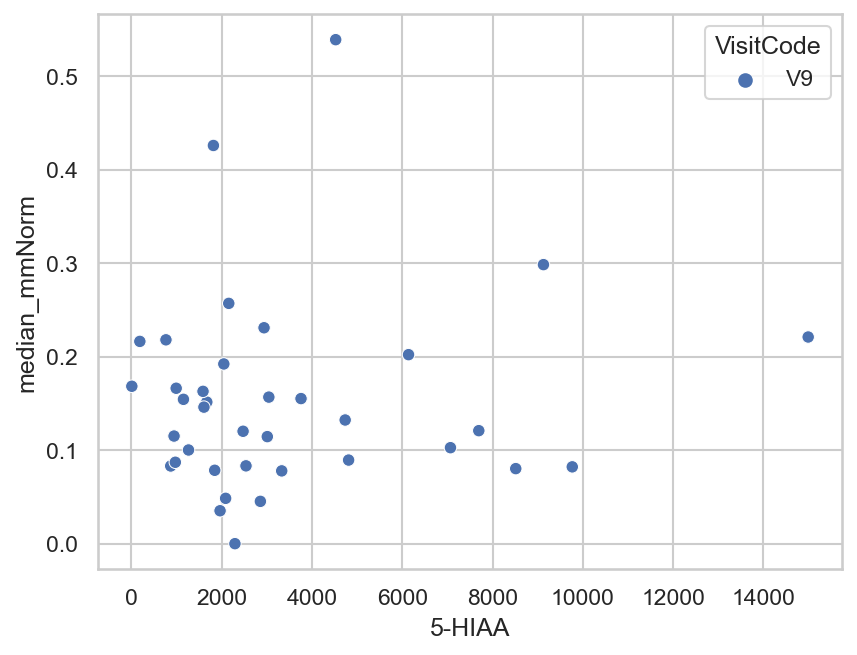

In [21]:
_ = sns.scatterplot(x='5-HIAA', y='median_mmNorm', hue='VisitCode',
                    data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V9'"))

Scatter plot showing correlation between ranks and titer as that is what is actually measured.

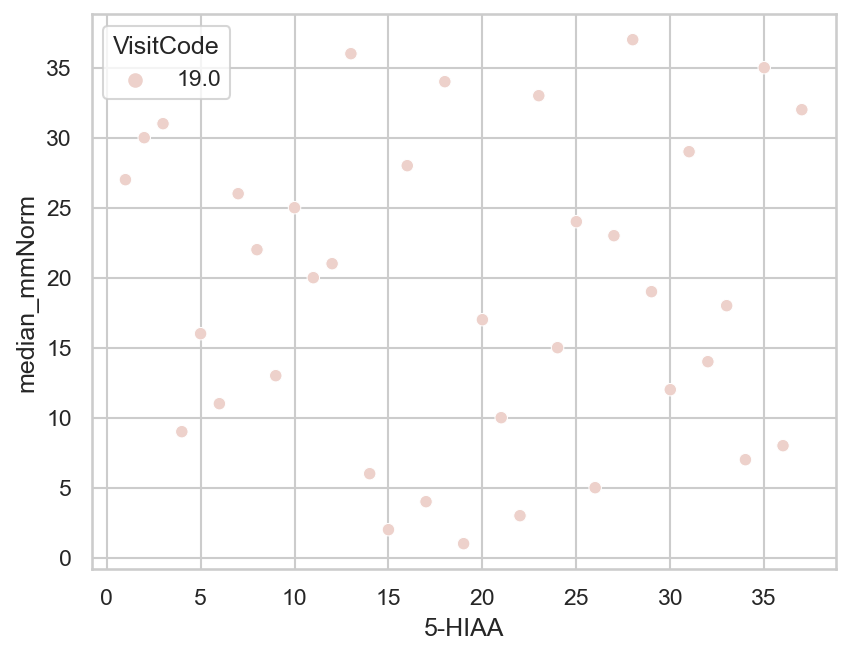

In [22]:
_ = sns.scatterplot(x='5-HIAA', y='median_mmNorm', hue='VisitCode',
                    data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1).query("VisitCode == 'V9'").rank())

Scatterplot of 5-HIAA un-normalized vs median titer with points colored by visit code. V5 is 2 months and V9 is one year.

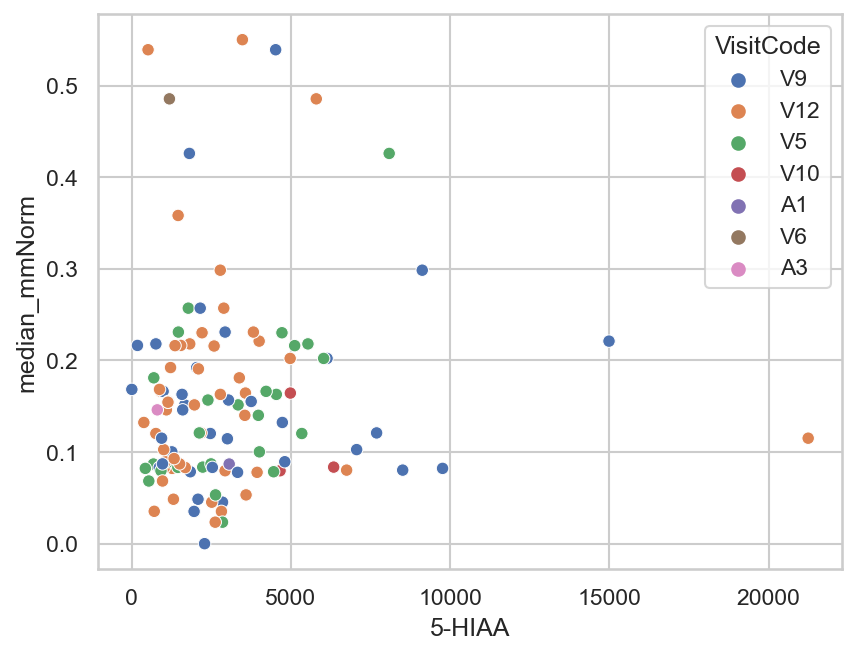

In [23]:
_ = sns.scatterplot(x='5-HIAA', y='median_mmNorm', hue='VisitCode',
                    data=pd.concat([metab_data.loc[meta_matched.index], meta_matched], axis=1))

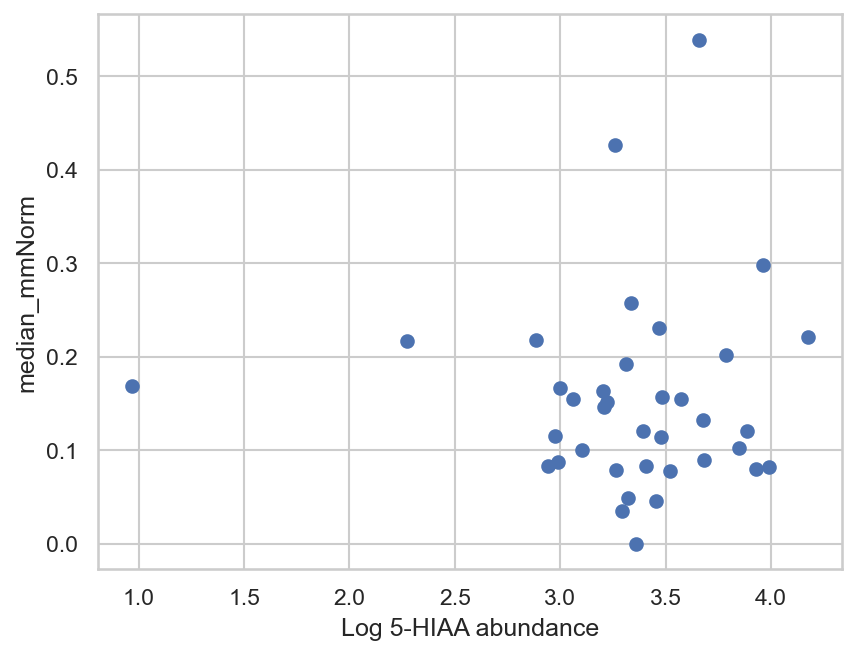

In [24]:
_ = plt.scatter(np.log10(metab_data.loc[meta_matched.query("VisitCode == 'V9'").index, '5-HIAA']), meta_matched.query("VisitCode == 'V9'")['median_mmNorm'])
_ = plt.xlabel('Log 5-HIAA abundance')
_ = plt.ylabel('median_mmNorm')

## Correlation with relative abundance data

Try normalizing metabolomics to relative abundance before doing correlations. Want to see if this will reduce number of correlated metabolites at 1 year.

In [25]:
metab_data_rel_v5 = metab_data_rel.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations_rel = metab_data_rel_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations_rel.columns = ['rho', 'p_value']
v5_correlations_rel['p_adj'] = p_adjust(v5_correlations_rel['p_value'])
v5_correlations_rel = v5_correlations_rel.sort_values('p_value')
v5_correlations_rel.head(15)

,rho,p_value,p_adj
Uridine,-0.492063,0.007820,0.706924
hydroxyphenyllactate,-0.445539,0.017498,0.706924
Guanosine,0.440066,0.019106,0.706924
5-HIAA,0.416530,0.027462,0.732144
Nicotinic acid,-0.398467,0.035708,0.732144
p-cresol sulfate,0.384784,0.043191,0.732144
L-Aspartic Acid,-0.379858,0.046171,0.732144
N-Carbamoyl-DL-aspartic acid,-0.344280,0.072813,0.885314
2-Deoxyuridine,-0.343733,0.073300,0.885314
Inosine,0.308155,0.110631,0.885314


Phenylpyruvic acide remains very significant at month 2 with no other significant results.

In [26]:
metab_data_rel_v9 = metab_data_rel.loc[meta_v9.index]
# metab_data_v9 = metab_data_v9[(metab_data_v9 > 0).sum(axis=0) > metab_data_v9.shape[0]*.2]
v9_correlations_rel = metab_data_rel_v9.apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations_rel.columns = ['rho', 'p_value']
v9_correlations_rel = v9_correlations_rel.loc[~pd.isna(v9_correlations_rel['p_value'])]
v9_correlations_rel['p_adj'] = p_adjust(v9_correlations_rel['p_value'])
v9_correlations_rel = v9_correlations_rel.sort_values('p_value')
v9_correlations_rel.head(30)

,rho,p_value,p_adj
trans-4-Hydroxy-L-proline,-0.359649,0.028793,0.940846
L-Serine,-0.334519,0.043003,0.940846
2-Deoxyuridine,0.316501,0.056326,0.940846
L-Aspartic Acid,-0.299905,0.071324,0.940846
Nicotinic acid,-0.296823,0.074426,0.940846
L-Threonine,-0.293030,0.078387,0.940846
p-cresol sulfate,0.285443,0.086800,0.940846
N-Acetylneuraminic acid,-0.279991,0.093265,0.940846
N-Acetyl D-galactosamine,-0.277857,0.095893,0.940846
L-Glutamine,-0.261498,0.117963,0.940846


30 things significant at 12 months with relative abundance normalization. Down from 45 (out of 52).

## Correlation with CLR'd data

Now let's try with CLR adjusted data.

In [27]:
metab_data_clr_v5 = metab_data_clr.loc[meta_v5.index]
# metab_data_v5 = metab_data_v5[(metab_data_v5 > 0).sum(axis=0) > metab_data_v5.shape[0]*.2]
v5_correlations_clr = metab_data_clr_v5.apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations_clr.columns = ['rho', 'p_value']
v5_correlations_clr['p_adj'] = p_adjust(v5_correlations_clr['p_value'])
v5_correlations_clr = v5_correlations_clr.sort_values('p_value')
v5_correlations_clr.head(12)

,rho,p_value,p_adj
Guanosine,0.415435,0.027913,0.994666
5-HIAA,0.406130,0.031996,0.994666
hydroxyphenyllactate,-0.384236,0.043514,0.994666
p-cresol sulfate,0.368911,0.053377,0.994666
Nicotinic acid,-0.357417,0.061865,0.994666
Melibiose,0.349754,0.068083,0.994666
N-Carbamoyl-DL-aspartic acid,-0.306513,0.112642,0.994666
serotonin,0.305419,0.113999,0.994666
Inosine,0.301040,0.119544,0.994666
L-Aspartic Acid,-0.290640,0.133508,0.994666


Hooray! Still Phenylpyruvic acid and nothing else.

In [28]:
metab_data_clr_v9 = metab_data_clr.loc[meta_v9.index]
# metab_data_v9 = metab_data_v9[(metab_data_v9 > 0).sum(axis=0) > metab_data_v9.shape[0]*.2]
v9_correlations_clr = metab_data_clr_v9.apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations_clr.columns = ['rho', 'p_value']
v9_correlations_clr = v9_correlations_clr.loc[~pd.isna(v9_correlations_clr['p_value'])]
v9_correlations_clr['p_adj'] = p_adjust(v9_correlations_clr['p_value'])
v9_correlations_clr = v9_correlations_clr.sort_values('p_value')
v9_correlations_clr.head(22)

,rho,p_value,p_adj
2-Deoxyuridine,0.362494,0.027462,0.951705
p-cresol sulfate,0.330014,0.046067,0.951705
L-Serine,-0.322902,0.051260,0.951705
Nicotinic acid,-0.298720,0.072505,0.951705
L-Phenylalanine,0.292793,0.078640,0.951705
Xanthosine,-0.291607,0.079914,0.951705
L-Threonine,-0.285206,0.087074,0.951705
L-Aspartic Acid,-0.256757,0.125022,0.951705
N-Acetyl D-galactosamine,-0.254386,0.128667,0.951705
N-Acetylneuraminic acid,-0.252489,0.131640,0.951705


Down to 21 significant things at 1 year with CLR so more "advanced" normalizations keep getting rid of significant results.

## Compare normalizations

To better understand what the normalization are shifting we compare between normalizations.

### V5

These are scatterplots of p-values between normalization at 2 months.

PearsonRResult(statistic=0.9423136073051837, pvalue=1.2573233674349883e-53)

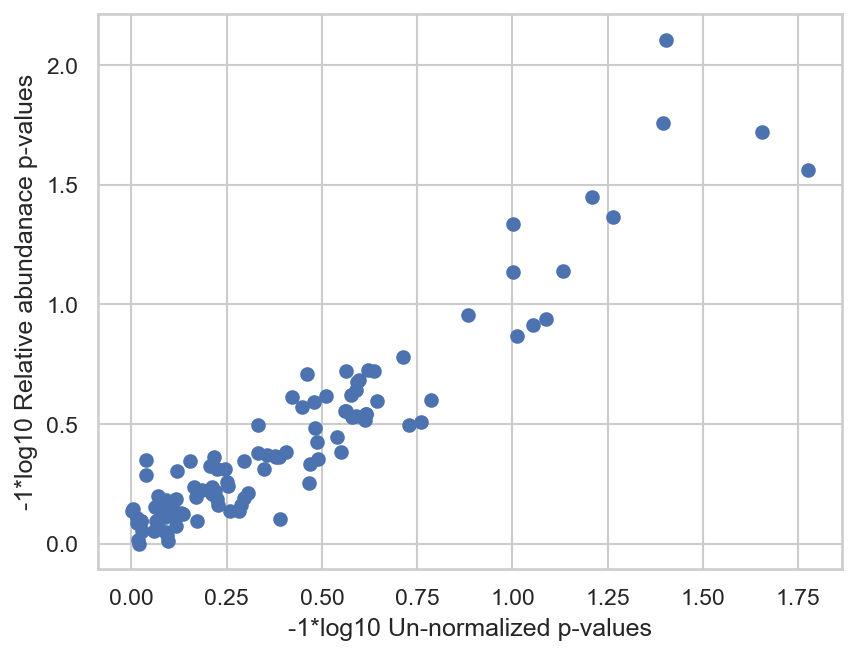

In [29]:
_ = plt.scatter(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_rel.loc[v5_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 Relative abundanace p-values')
pearsonr(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_rel.loc[v5_correlations.index, 'p_value']))

Un-normalized and relative abundance are highly correlated but a bit of variance.

PearsonRResult(statistic=0.9149979088419075, pvalue=8.95652368336839e-45)

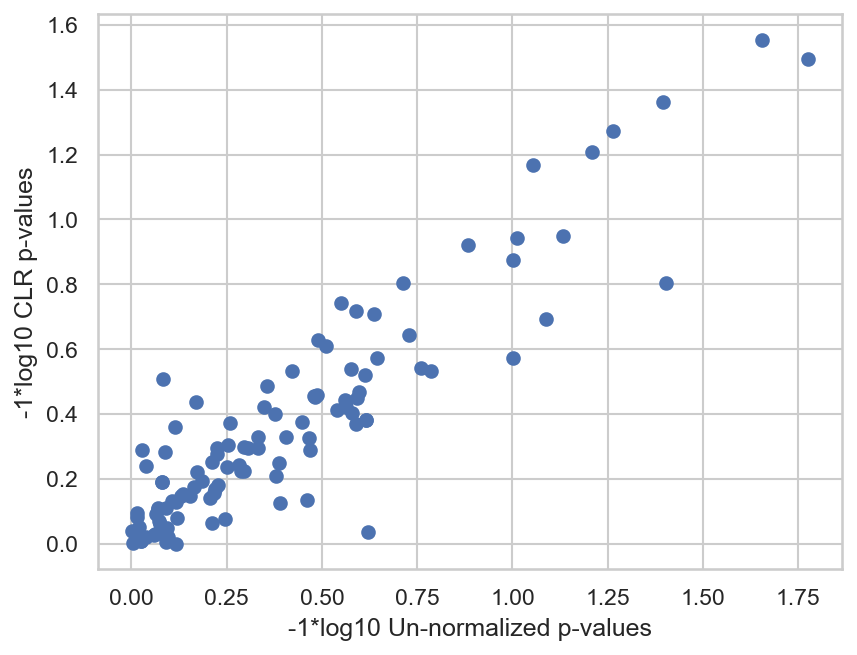

In [30]:
_ = plt.scatter(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v5_correlations['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations.index, 'p_value']))

Much more spread with un-normalized vs CLR.

PearsonRResult(statistic=0.8595175132598343, pvalue=1.4939194319193217e-33)

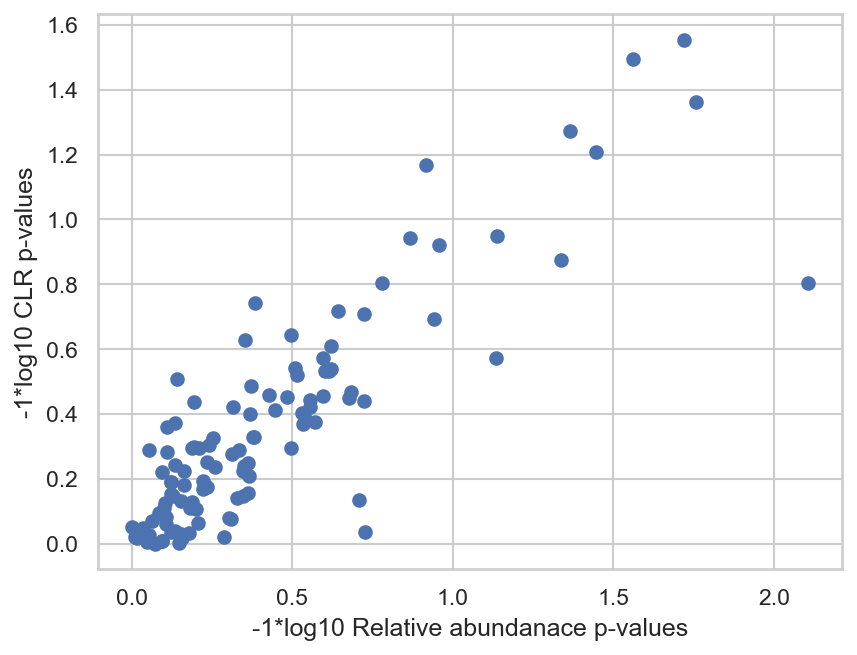

In [31]:
_ = plt.scatter(-1*np.log10(v5_correlations_rel['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations_rel.index, 'p_value']))
_ = plt.xlabel('-1*log10 Relative abundanace p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v5_correlations_rel['p_value']), -1*np.log10(v5_correlations_clr.loc[v5_correlations_rel.index, 'p_value']))

Less correlation between relative abundance and CLR but still pretty good.

Across all normalizations phenylpyruvic acid is super significant. You can definitely see that relative abundance and CLR shift the p-value distributions but they are much more strongly correlated with each other than the raw data.

### V9

Looking at the 1 year results.

To do:
* Try plotting L-tryptophan-D5, it is a standard, potentially use as a normalization factor (?)

In [32]:
set(v9_correlations.query('p_adj < .05').index) & set(v9_correlations_rel.query('p_adj < .05').index) & set(v9_correlations_clr.query('p_adj < .05').index)

set()

These are the 10 compounds that are significant in all 3 methods. The L-tryptophan-D5 is a spike-in. There are multiple spike-ins used and these is the only one that comes us as significant.

/Users/shaffmic/miniconda3/envs/imc/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


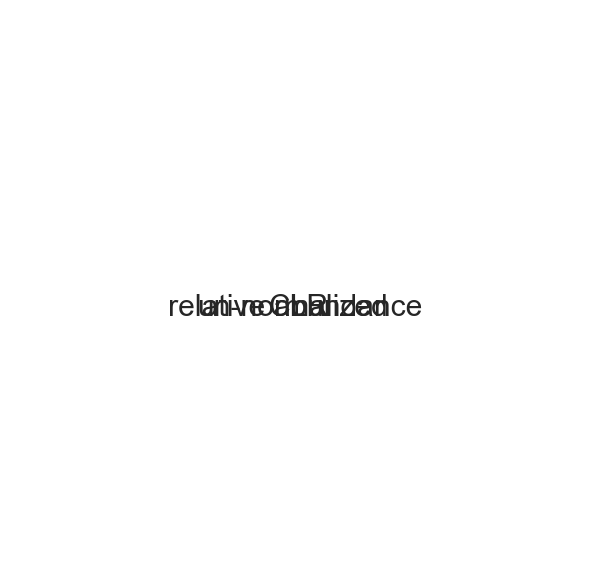

In [33]:
_ = venn3([set(v9_correlations.query('p_adj < .05').index), set(v9_correlations_rel.query('p_adj < .05').index), set(v9_correlations_clr.query('p_adj < .05').index)], set_labels=('un-normalized', 'relative abundance', 'CLR'))

The venn diagram shows the 10 that are shared by all. 20 are only in the normalized data. Relative abundance doesn't add anything unique and CLR adds two unique results.

PearsonRResult(statistic=0.8271895288562003, pvalue=4.7600578110268337e-29)

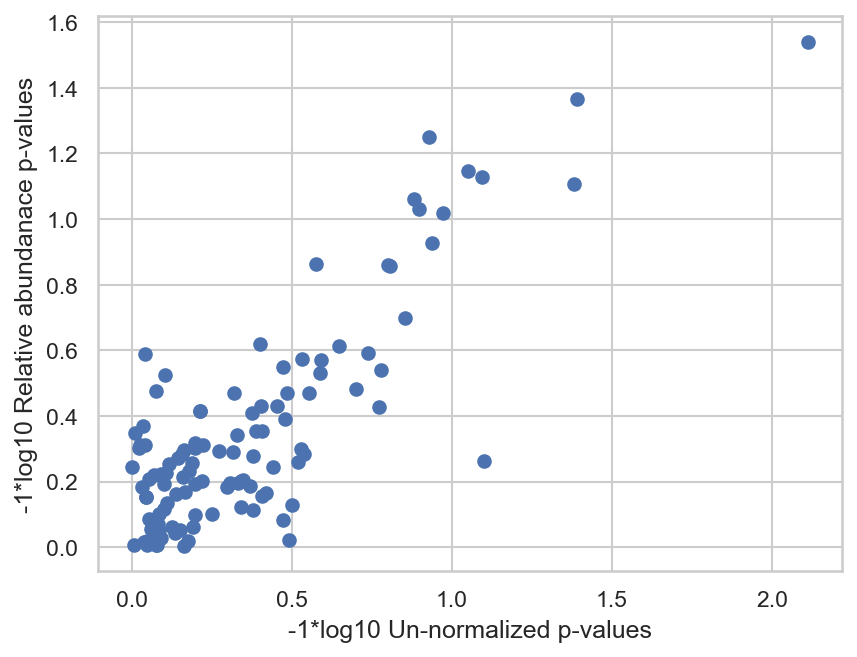

In [34]:
_ = plt.scatter(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_rel.loc[v9_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 Relative abundanace p-values')
pearsonr(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_rel.loc[v9_correlations.index, 'p_value']))

Much worse correlation between normalization strategies at one year time point.

PearsonRResult(statistic=0.4946819535624442, pvalue=3.417823844785238e-08)

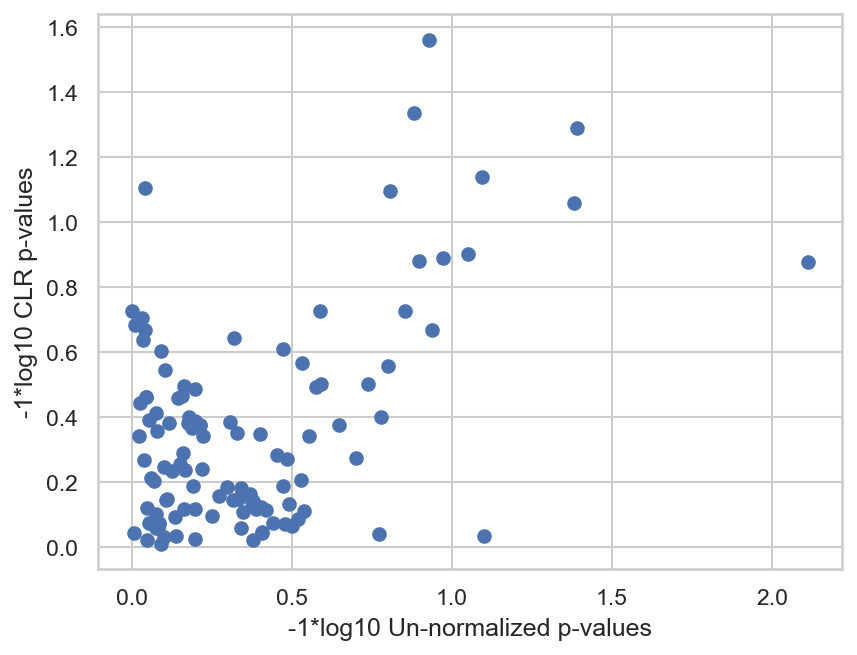

In [35]:
_ = plt.scatter(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations.index, 'p_value']))
_ = plt.xlabel('-1*log10 Un-normalized p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v9_correlations['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations.index, 'p_value']))

Much worse correlation between normalization strategies at one year time point.

PearsonRResult(statistic=0.7948366038030101, pvalue=2.1552737495252317e-25)

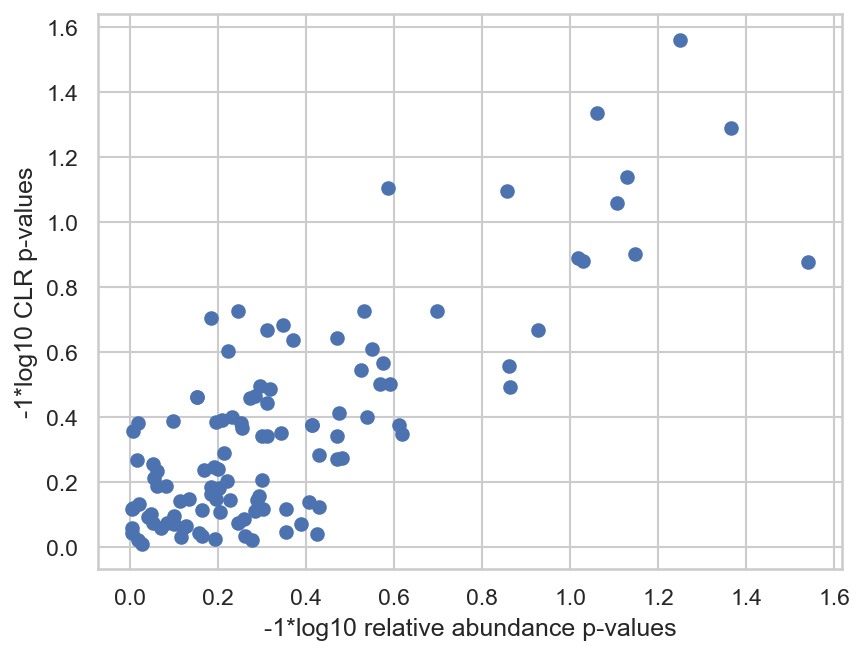

In [36]:
_ = plt.scatter(-1*np.log10(v9_correlations_rel['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations_rel.index, 'p_value']))
_ = plt.xlabel('-1*log10 relative abundance p-values')
_ = plt.ylabel('-1*log10 CLR p-values')
pearsonr(-1*np.log10(v9_correlations_rel['p_value']), -1*np.log10(v9_correlations_clr.loc[v9_correlations_rel.index, 'p_value']))

Much worse correlation between normalization strategies at one year time point.

## Plot tryptophan vs titers

This is the spike-in which was found to be significant at year 1.

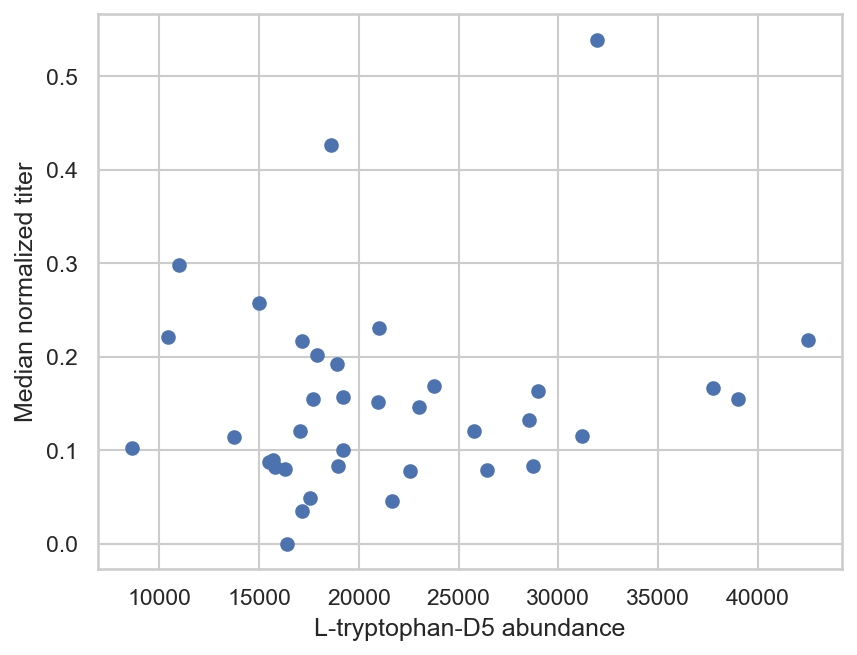

In [37]:
_ = plt.scatter(metab_data_v9.loc[meta_v9.index, 'L-tryptophan-D5'], meta_v9['median_mmNorm'])
_ = plt.xlabel('L-tryptophan-D5 abundance')
_ = plt.ylabel('Median normalized titer')

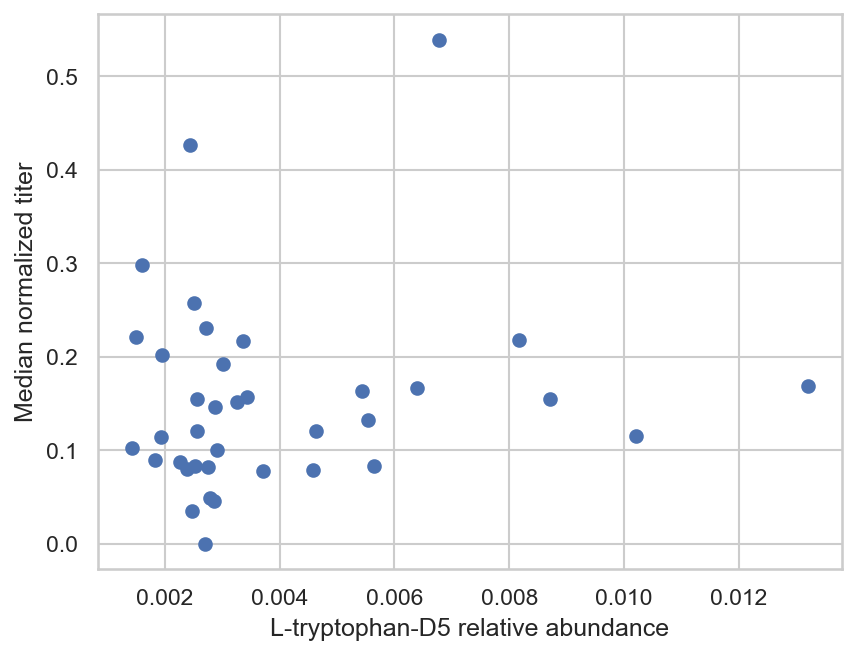

In [38]:
_ = plt.scatter(metab_data_rel_v9.loc[meta_v9.index, 'L-tryptophan-D5'], meta_v9['median_mmNorm'])
_ = plt.xlabel('L-tryptophan-D5 relative abundance')
_ = plt.ylabel('Median normalized titer')

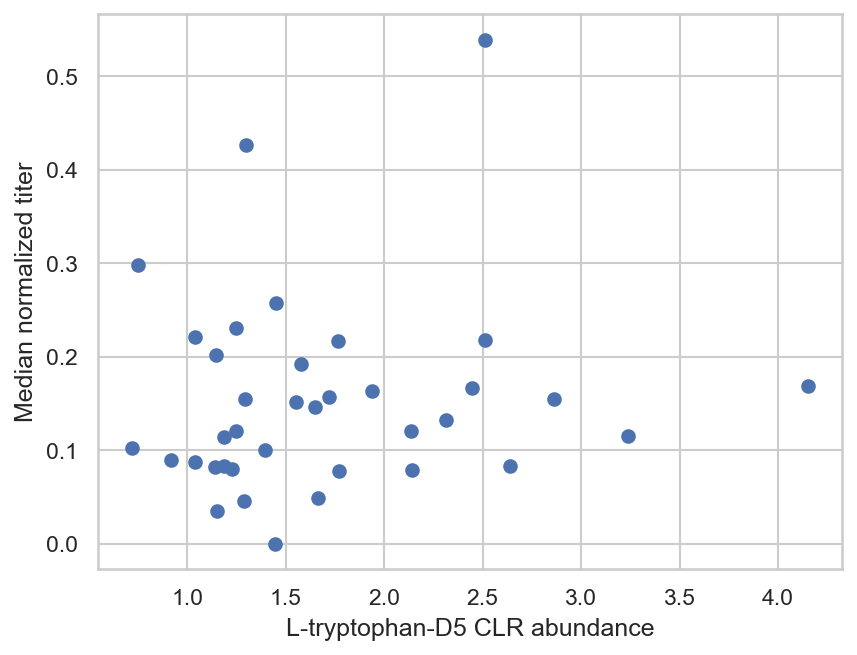

In [39]:
_ = plt.scatter(metab_data_clr_v9.loc[meta_v9.index, 'L-tryptophan-D5'], meta_v9['median_mmNorm'])
_ = plt.xlabel('L-tryptophan-D5 CLR abundance')
_ = plt.ylabel('Median normalized titer')

It looks pretty correlated no matter what normalization you use. This make me hesitant to use the 1 year time point metabolomics data.

## Correlate un-normalized with separate median titers

Now that we have looked at the combined median titers with both time points we will split into the DTAPHib and PCV medians separately.

### 2 month DTap hib

In [40]:
v5_DTAPHib_correlations = metab_data_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
L-asparagine,0.476738,0.010320,0.603381
L-Proline,0.461412,0.013455,0.603381
p-hydroxy-hippuric acid,0.448672,0.016630,0.603381
L-Leucine,0.431856,0.021743,0.603381
hippurate,0.388615,0.040980,0.909767


Three things are significant after FDR correction when correlating 2 month titers with DTAPHib titers. Phenylpyruvic acid still and additionally pyruvic acid and 1-Methyl-1-butanol.

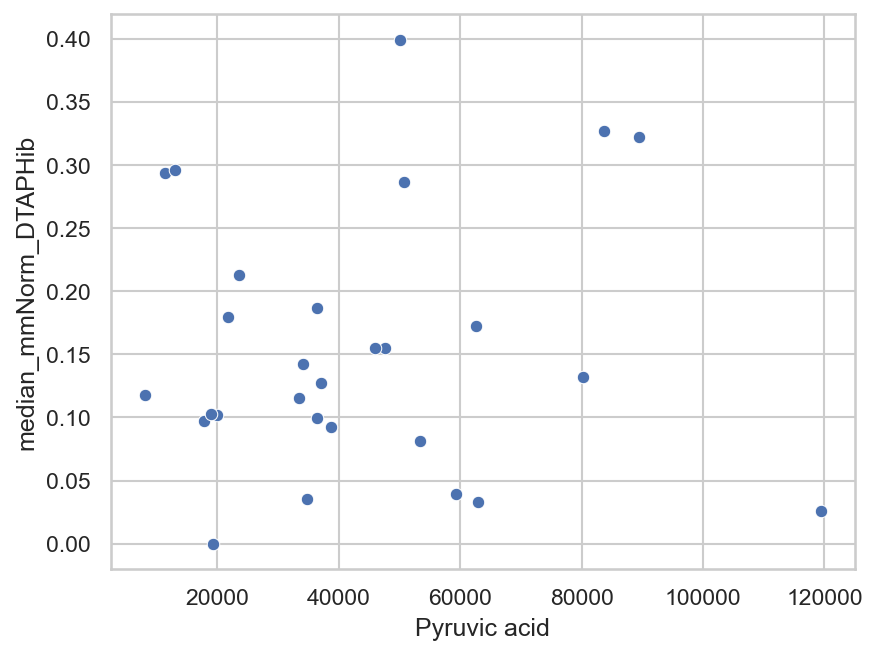

In [41]:
metab_data_v5_w_titer = metab_data_v5.copy()
metab_data_v5_w_titer['median_mmNorm_DTAPHib'] = meta_v5.loc[metab_data_v5_w_titer.index, 'median_mmNorm_DTAPHib']
_ = sns.scatterplot(x='Pyruvic acid', y='median_mmNorm_DTAPHib', data=metab_data_v5_w_titer)

Very similar curve to what we saw with phenylpyruvic acid with the median of all titers.

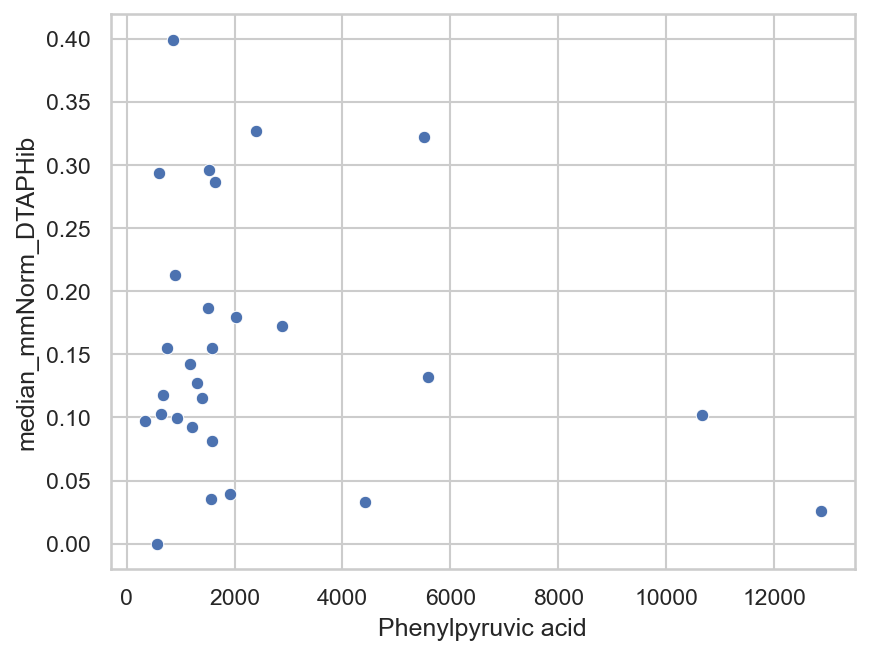

In [42]:
_ = sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm_DTAPHib', data=metab_data_v5_w_titer)

Again very similar to the other significant curves. This one might be a bit more extreme/scattered. If you have < 2000 Phenylpyruvic acid acid then you are very likely to have high titers.

### 2 month PCV

Same idea as above but with the PCV titers instead of the DTapHib titers. There are two babies who have a median titer but do not have a median PCV titer because of a lack of measured PCV titers.

In [43]:
meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]
meta_PCV.head()

,BabyN,VisitCode,VisitDate,PT,Dip,FHA,PRN,TET,PRP (Hib),PCV ST1,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
P251_V9_09092019,251,V9,09092019,5.0,0.22,1.5,2.5,0.17,7.35,26.071367,...,0.045279,0.013593,0.113246,False,True,False,False,True,True,NVR
P261_V12_10222020,261,V12,10222020,21.0,1.03,8.0,125.0,0.98,1.05,31.157284,...,0.03523,0.102296,0.030523,True,True,False,True,True,True,NVR
P226_V12_09302020,226,V12,09302020,16.0,0.68,20.0,32.0,3.26,3.57,23.329774,...,0.082202,0.097174,0.057712,True,True,True,True,True,True,NVR
P210_V5_05062018,210,V5,05062018,19.0,0.66,23.0,64.0,0.79,2.58,156.531647,...,0.083593,0.115757,0.063515,True,True,True,True,True,True,NVR
P230_V9_07102019,230,V9,07102019,11.0,0.25,5.0,12.0,0.05,0.3,81.383885,...,0.048516,0.02296,0.088023,True,True,False,True,False,True,NVR


In [44]:
meta_PCV_v5 = meta_PCV.query("VisitCode == 'V5'")
metab_data_PCV_v5 = metab_data.loc[meta_PCV_v5.index].transpose()
metab_data_PCV_v5 = metab_data_PCV_v5.loc[(metab_data_PCV_v5 > 0).sum(axis=1) > metab_data_PCV_v5.shape[1]*.2]
v5_PCV_correlations = metab_data_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
5-HIAA,0.584018,0.001103,0.122408
Guanosine,0.506911,0.005906,0.327790
Nicotinic acid,-0.415435,0.027913,0.811344
Inosine,0.407772,0.031243,0.811344
Uridine,-0.396825,0.036547,0.811344


Only one significantly correlated with PCV and it's our friend Phenylpyruvic acid.

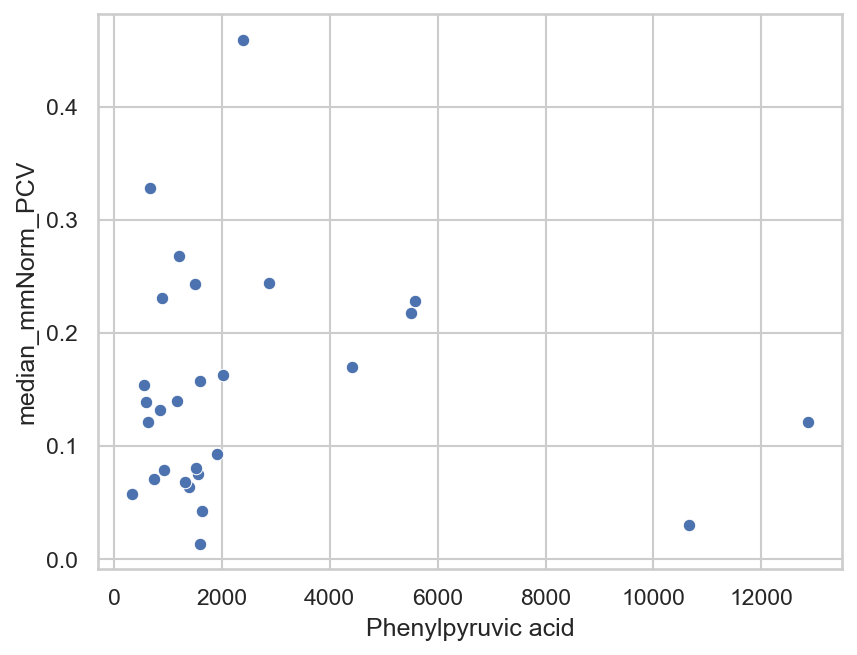

In [45]:
metab_data_PCV_v5_w_titer = metab_data_PCV_v5.copy().transpose()
metab_data_PCV_v5_w_titer['median_mmNorm_PCV'] = meta_v5.loc[metab_data_PCV_v5_w_titer.index, 'median_mmNorm_PCV']
# metab_data_PCV_v5_w_titer
_ = sns.scatterplot(x='Phenylpyruvic acid', y='median_mmNorm_PCV', data=metab_data_PCV_v5_w_titer)

Different compound same curve.

### 12 month DTAPHib

In [46]:
v9_DTAPHib_correlations = metab_data_v9.apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head(15)

,rho,p_value,p_adj
L-Tryptophan,-0.295164,0.076140,0.998889
p-cresol sulfate,0.279753,0.093554,0.998889
Creatinine,0.242072,0.148880,0.998889
7oxoCA,-0.237790,0.156425,0.998889
Succinic acid,-0.237079,0.157704,0.998889
Oxamic acid,-0.227359,0.175958,0.998889
4-Hydroxybenzoic acid,-0.198909,0.237909,0.998889
L-Aspartic Acid,-0.195116,0.247160,0.998889
L-Threonine,-0.195116,0.247160,0.998889
Guanosine,-0.192271,0.254255,0.998889


Lots significant again. I don't trust these results.

### 12 month PCV

In [47]:
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")
metab_data_PCV_v9 = metab_data.loc[meta_PCV_v9.index].transpose()
metab_data_PCV_v9 = metab_data_PCV_v9.loc[(metab_data_PCV_v9 > 0).sum(axis=1) > metab_data_PCV_v9.shape[1]*.2]
v9_PCV_correlations = metab_data_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head(15)

,rho,p_value,p_adj
trans-4-Hydroxy-L-proline,-0.566382,0.000258,0.028639
L-Threonine,-0.433618,0.007338,0.302729
L-Serine,-0.422712,0.009148,0.302729
N-Acetyl D-galactosamine,-0.413752,0.010909,0.302729
L-tryptophan-D5,0.368184,0.024953,0.553965
N-Acetyl-alpha-D-glucosamine 1-phosphate,-0.338549,0.040404,0.683281
L-Citrulline,-0.306069,0.065426,0.683281
N-Acetylneuraminic acid,-0.302750,0.068552,0.683281
xanthurenic acid,-0.299905,0.071324,0.683281
N-Carbamoyl-DL-aspartic acid,-0.298026,0.073203,0.683281


One significant metabolite.

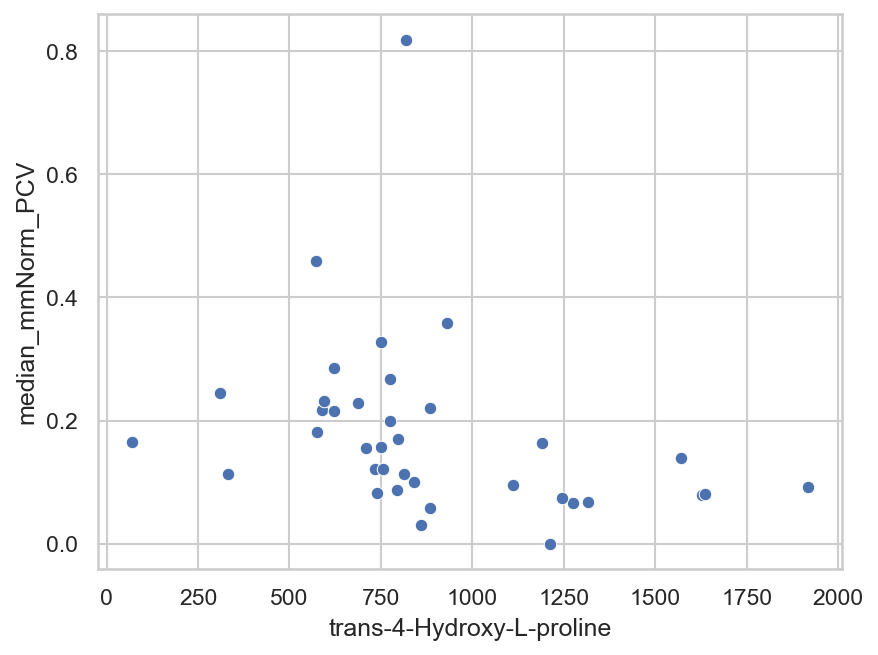

In [48]:
metab_data_PCV_v9_w_titer = metab_data_PCV_v9.copy().transpose()
metab_data_PCV_v9_w_titer['median_mmNorm_PCV'] = meta_v9.loc[metab_data_PCV_v9_w_titer.index, 'median_mmNorm_PCV']
_ = sns.scatterplot(x='trans-4-Hydroxy-L-proline', y='median_mmNorm_PCV', data=metab_data_PCV_v9_w_titer)

## Correlate relative abundance with separate median titers

Now we will do the same thing but with relative abundance for PCV and DTAPHib.

### 2 month DTAPHib

In [49]:
v5_DTAPHib_correlations_rel = metab_data_rel_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations_rel.columns = ['rho', 'p_value']
v5_DTAPHib_correlations_rel['p_adj'] = p_adjust(v5_DTAPHib_correlations_rel['p_value'])
v5_DTAPHib_correlations_rel = v5_DTAPHib_correlations_rel.sort_values('p_value')
v5_DTAPHib_correlations_rel.head()

,rho,p_value,p_adj
p-hydroxy-hippuric acid,0.446634,0.017191,0.924327
L-Leucine,0.412151,0.029303,0.924327
L-Isoleucine,0.402299,0.033811,0.924327
L-asparagine,0.400657,0.034614,0.924327
hippurate,0.384784,0.043191,0.924327


Same three compounds.

### 2 month PCV

In [50]:
metab_data_PCV_rel_v5 = metab_data_rel.loc[meta_PCV_v5.index].transpose()
v5_PCV_correlations_rel = metab_data_PCV_rel_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations_rel.columns = ['rho', 'p_value']
v5_PCV_correlations_rel['p_adj'] = p_adjust(v5_PCV_correlations_rel['p_value'])
v5_PCV_correlations_rel = v5_PCV_correlations_rel.sort_values('p_value')
v5_PCV_correlations_rel.head()

,rho,p_value,p_adj
5-HIAA,0.563218,0.001805,0.200342
Guanosine,0.515052,0.005037,0.279541
Uridine,-0.472359,0.011146,0.412386
Nicotinic acid,-0.437329,0.019954,0.553731
Inosine,0.411604,0.029540,0.625508


Just phenylpyruvic acid.

### 12 month DTAPHib

In [51]:
v9_DTAPHib_correlations_rel = metab_data_rel_v9.apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations_rel.columns = ['rho', 'p_value']
v9_DTAPHib_correlations_rel['p_adj'] = p_adjust(v9_DTAPHib_correlations_rel['p_value'])
v9_DTAPHib_correlations_rel = v9_DTAPHib_correlations_rel.sort_values('p_value')
v9_DTAPHib_correlations_rel.head(25)

,rho,p_value,p_adj
L-Tryptophan,-0.315552,0.057109,0.994404
p-cresol sulfate,0.293741,0.077632,0.994404
L-Aspartic Acid,-0.287103,0.084903,0.994404
Creatinine,0.232101,0.166874,0.994404
3-phenyllactic acid,0.228070,0.174574,0.994404
7oxoCA,-0.225699,0.179220,0.994404
L-Threonine,-0.219298,0.192201,0.994404
L-tryptophan-D5,-0.212423,0.206865,0.994404
Oxamic acid,-0.198672,0.238480,0.994404
UDCA or HDCA,0.196064,0.244825,0.994404


Lots significant again. I don't trust these results.

### 12 month PCV

In [52]:
metab_data_PCV_rel_v9 = metab_data_rel.loc[meta_PCV_v9.index].transpose()
v9_PCV_correlations_rel = metab_data_PCV_rel_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations_rel.columns = ['rho', 'p_value']
v9_PCV_correlations_rel['p_adj'] = p_adjust(v9_PCV_correlations_rel['p_value'])
v9_PCV_correlations_rel = v9_PCV_correlations_rel.sort_values('p_value')
v9_PCV_correlations_rel.head(13)

,rho,p_value,p_adj
trans-4-Hydroxy-L-proline,-0.521811,0.000925,0.102722
N-Acetyl D-galactosamine,-0.429113,0.008044,0.409413
L-Serine,-0.410621,0.011589,0.409413
N-Acetyl-alpha-D-glucosamine 1-phosphate,-0.397819,0.014754,0.409413
L-Threonine,-0.365813,0.025975,0.576636
N-Acetylneuraminic acid,-0.334282,0.043160,0.603896
xanthurenic acid,-0.330251,0.045902,0.603896
2-3-Dihydroxyisovalerate,0.329777,0.046233,0.603896
Glyceric acid,-0.322902,0.051260,0.603896
Homocitrate,0.318872,0.054405,0.603896


Lots significant again. I don't trust these results.

## Correlate CLR with separate median titers

### 2 month correlations

In [53]:
v5_DTAPHib_correlations_clr = metab_data_clr_v5.apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations_clr.columns = ['rho', 'p_value']
v5_DTAPHib_correlations_clr['p_adj'] = p_adjust(v5_DTAPHib_correlations_clr['p_value'])
v5_DTAPHib_correlations_clr = v5_DTAPHib_correlations_clr.sort_values('p_value')
v5_DTAPHib_correlations_clr.head(8)

,rho,p_value,p_adj
kynurenic acid,-0.452655,0.015577,0.993383
L-asparagine,0.394089,0.037980,0.993383
Melibiose,0.382047,0.044827,0.993383
p-hydroxy-hippuric acid,0.364532,0.056496,0.993383
L-Leucine,0.353585,0.064916,0.993383
Inosine,-0.349206,0.068545,0.993383
Vanillic acid,0.305966,0.113319,0.993383
alpha-D(+)Mannose 1-phosphate,0.291188,0.132744,0.993383


In [54]:
metab_data_PCV_clr_v5 = metab_data_clr.loc[meta_PCV_v5.index].transpose()
v5_PCV_correlations_clr = metab_data_PCV_clr_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations_clr.columns = ['rho', 'p_value']
v5_PCV_correlations_clr['p_adj'] = p_adjust(v5_PCV_correlations_clr['p_value'])
v5_PCV_correlations_clr = v5_PCV_correlations_clr.sort_values('p_value')
v5_PCV_correlations_clr.head()

,rho,p_value,p_adj
5-HIAA,0.577449,0.001293,0.143518
Guanosine,0.501916,0.006500,0.360755
Inosine,0.427477,0.023268,0.860900
Nicotinic acid,-0.391899,0.039158,0.912747
serotonin,0.341544,0.075271,0.912747


Same results as all other 2 month correlations for DTAPHib and PCV.

### 12 month correlations

In [55]:
v9_DTAPHib_correlations_clr = metab_data_clr_v9.apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations_clr.columns = ['rho', 'p_value']
v9_DTAPHib_correlations_clr['p_adj'] = p_adjust(v9_DTAPHib_correlations_clr['p_value'])
v9_DTAPHib_correlations_clr = v9_DTAPHib_correlations_clr.sort_values('p_value')
v9_DTAPHib_correlations_clr.head(27)

,rho,p_value,p_adj
L-Aspartic Acid,-0.318160,0.054976,0.983307
p-cresol sulfate,0.297060,0.074184,0.983307
L-Tryptophan,-0.293741,0.077632,0.983307
3-phenyllactic acid,0.282598,0.090129,0.983307
L-Threonine,-0.238739,0.154730,0.983307
UDCA or HDCA,0.229018,0.172740,0.983307
7oxoCA,-0.224040,0.182524,0.983307
Creatinine,0.222617,0.185390,0.983307
L-Glutamine,-0.215505,0.200198,0.983307
Vanillic acid,0.210763,0.210518,0.983307


In [56]:
metab_data_PCV_clr_v9 = metab_data_clr.loc[meta_PCV_v9.index].transpose()
v9_PCV_correlations_clr = metab_data_PCV_clr_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations_clr.columns = ['rho', 'p_value']
v9_PCV_correlations_clr['p_adj'] = p_adjust(v9_PCV_correlations_clr['p_value'])
v9_PCV_correlations_clr = v9_PCV_correlations_clr.sort_values('p_value')
v9_PCV_correlations_clr.head()

,rho,p_value,p_adj
L-Serine,-0.435752,0.007022,0.610403
trans-4-Hydroxy-L-proline,-0.401375,0.013809,0.610403
N-Acetyl D-galactosamine,-0.385965,0.018305,0.610403
L-Threonine,-0.375533,0.021997,0.610403
p-cresol sulfate,0.354433,0.031369,0.696396


Lots significant again. I don't trust these results.

## Compare normalizations for split titers

Build up some venn diagrams to compare normalizations for the split titers.

/Users/shaffmic/miniconda3/envs/imc/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


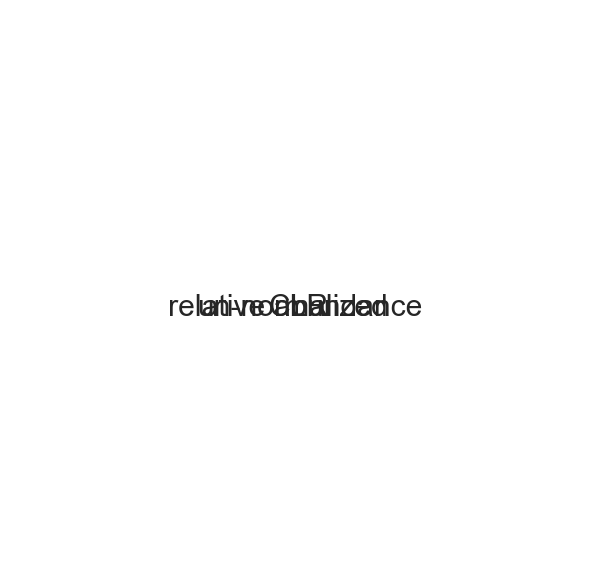

In [57]:
_ = venn3([set(v9_DTAPHib_correlations.query('p_adj < .05').index),
           set(v9_DTAPHib_correlations_rel.query('p_adj < .05').index),
           set(v9_DTAPHib_correlations_clr.query('p_adj < .05').index)], set_labels=('un-normalized',
                                                                                     'relative abundance', 'CLR'))

/Users/shaffmic/miniconda3/envs/imc/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")
/Users/shaffmic/miniconda3/envs/imc/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


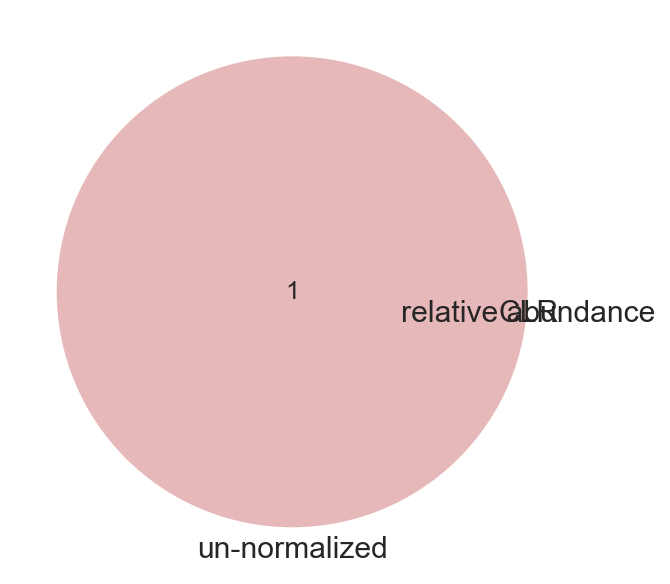

In [58]:
_ = venn3([set(v9_PCV_correlations.query('p_adj < .05').index),
           set(v9_PCV_correlations_rel.query('p_adj < .05').index),
           set(v9_PCV_correlations_clr.query('p_adj < .05').index)], set_labels=('un-normalized',
                                                                                     'relative abundance', 'CLR'))